# CMSC320 Tutorial - FAANG Stock Prices
## Peter Geertsema - UID 116462426
The world of quantitative finance is a highly competitive (and highly lucrative) field. Rather than a fundamentals-based approach (which has humans picking individual stocks), quantitative researchers develop trading strategies, which are then exploited by computers across an entire universe of stocks (typically largest 5,000, but in theory can be anything).  Many of the world's largest investment banks employ thousands of people to develop trading strategies based on statistical methods. Most of the strategies have a short lifespan as they're likely to be completely exploited. As a result, there is an arms race of sorts, leading to large financial firms gobbling up ever increasing amounts of data and computational power to gain an edge.

In this tutorial, we will be using the stock prices of the FAANG companies (Facebook, Amazon, Apple, Netflix, Google) in an attempt to predict their share prices in the future. Given how difficult of a task this is, we're unlikely to be very successful. Either way, however, the statistical and ML techniques used in quantitative finance are applicable anywhere big data is, so we should all be able to learn.

# Data Collection
Before we start anything, there are plenty of super useful libraries we'll be using that are imported here.

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.formula.api as smf
import sklearn.linear_model
import sklearn.ensemble

## Sources
I will be pulling data from https://www.kaggle.com/aayushmishra1512/faang-complete-stock-data, which has the share prices of Facebook, Amazon, Apple, Netflix, and Google. Every trading day has includes the opening, closing, high, low prices, alongside the trading volume and closing price adjusted for distributions. All of these factors will prove useful throughout our analysis.

I have downloaded the necessary CSV's, and will read them using pandas below.

In [2]:
companies = ['Facebook', 'Amazon', 'Apple', 'Netflix', 'Google']
data = [pd.read_csv(f'{c}.csv') for c in companies]

Let's take a quick peek at Facebook's stock data so we can get a better idea of what we're working with.

In [3]:
data[0].head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-05-18,42.049999,45.000000,38.000000,38.230000,38.230000,573576400
1,2012-05-21,36.529999,36.660000,33.000000,34.029999,34.029999,168192700
2,2012-05-22,32.610001,33.590000,30.940001,31.000000,31.000000,101786600
3,2012-05-23,31.370001,32.500000,31.360001,32.000000,32.000000,73600000
4,2012-05-24,32.950001,33.209999,31.770000,33.029999,33.029999,50237200


# Data Cleaning
Now that we've read in the data for each stock, there is some minor cleanup to attend to before we can do any serious data science. 

The data is already the expected type except for the 'Date' column. Here all we have to do it convert it column to a `datetime` instance for ease of comparison. Pandas makes this nice and easy with `pd.to_datetime()`. We also want to convert `Adj Close` to `Adj_Close`, since having spaces in column names can be finicky.

Since we're primarily interested in how the share price changes, it will behoove us to calculate daily percentage change and cumulative returns now. We will call the daily change `pct_change` and the cumulative return `total_return`. We will also include `pct_yesterday`, which will be 1-day lagged for `pct_change` for predicting day x's return using the return from day (x-1). When calculating the daily percentage change, the very first row for each share will have a value of NaN, so `pct_yesterday` will have NaNs the first two rows. We have enough data that we can safely drop these to avoid any issues later on. 

In [4]:
for df in data:
    df['Date'] = pd.to_datetime(df['Date'])
    df['pct_change'] = df['Close'].pct_change()
    df['pct_yesterday'] = df['pct_change'].shift(1)
    df.dropna(inplace=True)
    df['total_return'] = df['pct_change'].cumsum()
    df['Adj_Close'] = df['Adj Close']
    df.drop(['Adj Close'], axis=1, inplace=True)

While having all our data in separate `DataFrame`s can be useful, it will generally be better for us to only have to deal with one.

Before merging though, we need to be able to differentiate between each stock. To favor readability, we will simply include the name of the company on each entry.

Since each of the separate `DataFrame`s have the same columns, we can simply use the `pd.concat()` function to merge all of them together. The resulting `DataFrame` will include all the rows in the constituent `DataFrame`s. To avoid duplicate indices, we call `reset_index()`, which just creates a new index starting at 0.

In [5]:
for name, df in zip(companies, data):
    df['name'] = name
price_data = pd.concat(data).reset_index(drop=True)

Let's take a look at our combined `DataFrame` to see what we'll be working with.

In [6]:
price_data

,Date,Open,High,Low,Close,Volume,pct_change,pct_yesterday,total_return,Adj_Close,name
0,2012-05-22,32.610001,33.590000,30.940001,31.000000,101786600.0,-0.089039,-0.109861,-0.089039,31.000000,Facebook
1,2012-05-23,31.370001,32.500000,31.360001,32.000000,73600000.0,0.032258,-0.089039,-0.056781,32.000000,Facebook
2,2012-05-24,32.950001,33.209999,31.770000,33.029999,50237200.0,0.032187,0.032258,-0.024594,33.029999,Facebook
3,2012-05-25,32.900002,32.950001,31.110001,31.910000,37149800.0,-0.033909,0.032187,-0.058502,31.910000,Facebook
4,2012-05-29,31.480000,31.690001,28.650000,28.840000,78063400.0,-0.096208,-0.033909,-0.154710,28.840000,Facebook
...,...,...,...,...,...,...,...,...,...,...,...
26550,2020-08-31,1643.569946,1644.500000,1625.329956,1629.530029,1321100.0,-0.006039,0.006699,4.141789,1629.530029,Google
26551,2020-09-01,1632.160034,1659.219971,1629.530029,1655.079956,1133800.0,0.015679,-0.006039,4.157468,1655.079956,Google
26552,2020-09-02,1668.010010,1726.099976,1660.189941,1717.390015,2476100.0,0.037648,0.015679,4.195116,1717.390015,Google
26553,2020-09-03,1699.520020,1700.000000,1607.709961,1629.510010,3180200.0,-0.051171,0.037648,4.143945,1629.510010,Google


# Exploratory Data Analysis
Since we're interested in predicting share performance over time, let's graph `total_return` and note any patterns. `total_return` is how much the share has gained from its first recorded share price. So a cumulative return of 1 indicates a 100% increase, 2 a 200% increase, etc. 

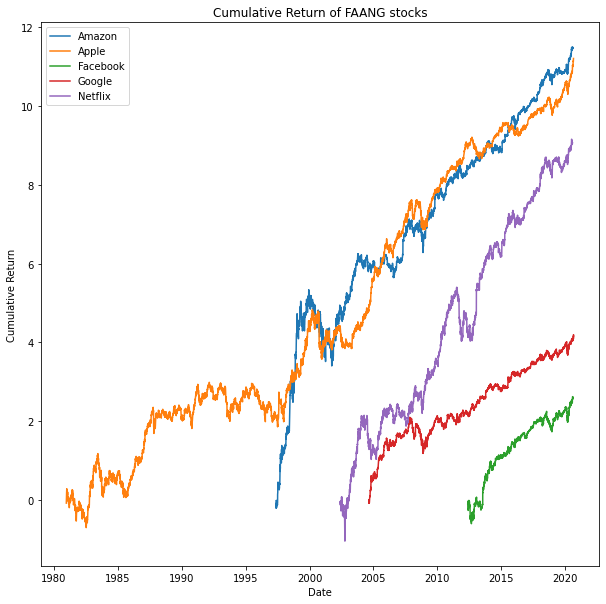

In [7]:
fig, ax = plt.subplots(figsize=(10,10))
for name, sub in price_data.groupby('name'):
    ax.plot(sub['Date'], sub['total_return'], label=name)
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Return')
ax.set_title('Cumulative Return of FAANG stocks')
ax.legend()

These shares all clearly strong upward trajectory, despite the frequent dips. Most of these dips appear to recover in 1-2 years, depending on their severity. 

Now that we've taken a look at how each of them perform over time an extended period, let's see how the distribution for each day works out. Since we've got so much data, a scatterplot is likely to be garbled and difficult to understand. Instead, we'll use a violinplot, which is effectively a fancier box and whisker plot which will show the distribution of `pct_change`.

Text(0.5, 1.0, 'Distribution of Daily Percentage Change by Company')

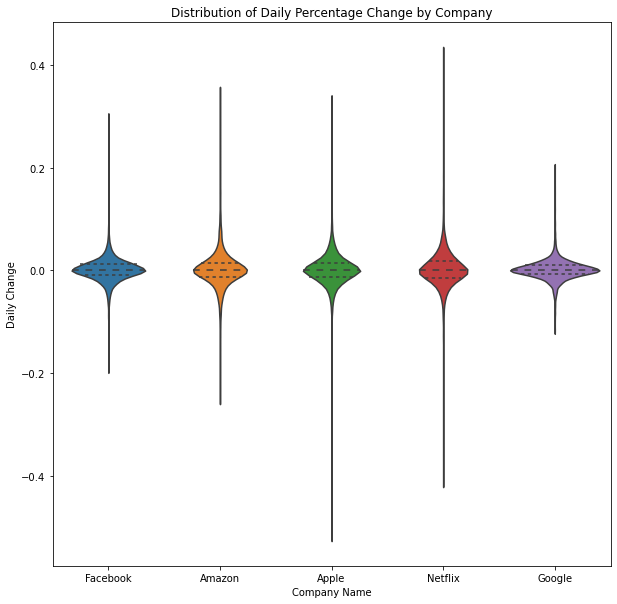

In [8]:
fig, ax = plt.subplots(figsize=(10,10))
sns.violinplot(ax=ax, data=price_data, x='name', y='pct_change', inner='quartile')
ax.set_xlabel('Company Name')
ax.set_ylabel('Daily Change')
ax.set_title('Distribution of Daily Percentage Change by Company')

Unsurprisingly, the vast majority of days don't see changes larger than a couple percent in either direction. Of particular interest though are the days that do see significant swings, since these are where a trading algorithm would make significant returns.

Let's take a look at swings more than 3 standard deviations from the mean. To accomplish this, we will use the `zscore()` function from `scipi.stats`. Documentation can be found [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.zscore.html), but essentially all it does is calculate the z-score for every value. This makes it easy to find outliers, since a z-score above 3 or below -3 indicates a value more than 3 standard deviations from the mean, which we are considering as outliers for the purposes of this analysis.

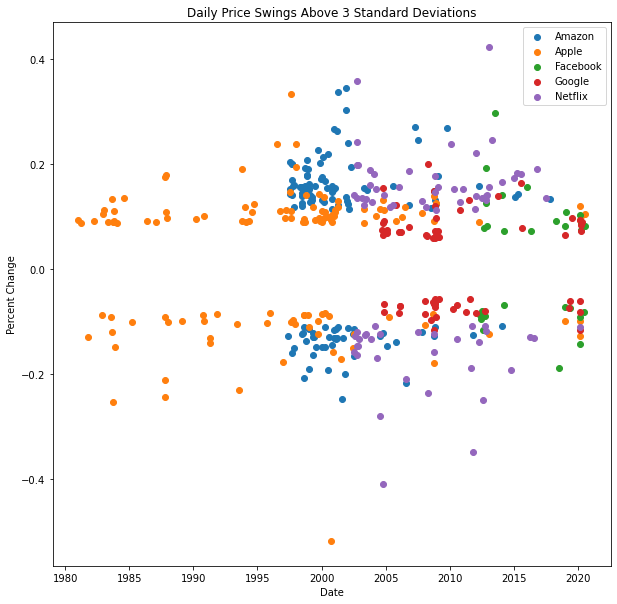

In [9]:
fig, ax = plt.subplots(figsize=(10,10))
for name, df in price_data.groupby('name'):
    z_scores = stats.zscore(df['pct_change'])
    sub = df[abs(z_scores) > 3]
    ax.scatter(sub['Date'], sub['pct_change'], label=name)
ax.set_xlabel('Date')
ax.set_ylabel('Percent Change')
ax.set_title('Daily Price Swings Above 3 Standard Deviations')
ax.legend()

Discerning a pattern from this chart doesn't seem to particularly feasible. One thing to note is that large swings in one FAANG stock do appear to correspond with big swings in others.

Let's test this by checking the correlation between `pct_change` for all our stocks. To accomplish this, we need to reshape our data a bit. The `corr()` function we will be using expects each entry to be on the same row. Right now, every row is a separate row and date. Since we're only interested in `pct_change` for this, we can safely ignore the other columns. We will be using the `pivot()` function, which can be read about [here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.pivot.html). Pivot let's us convert our separate rows for each company to a single row for each day. We say index is `Date`, since we want each row to contain all the data for a particular day. The new columns being created are stored in `name` (Facebook, Amazon, etc), and the values we are interested in are stored in `pct_change`.

The result of the pivoting operation can be seen below:

In [10]:
daily_returns = price_data.pivot(index='Date', columns='name', values='pct_change')
daily_returns

name,Amazon,Apple,Facebook,Google,Netflix
Date,,,,,
1980-12-16,NaN,-0.073398,NaN,NaN,NaN
1980-12-17,NaN,0.024751,NaN,NaN,NaN
1980-12-18,NaN,0.028992,NaN,NaN,NaN
1980-12-19,NaN,0.061029,NaN,NaN,NaN
1980-12-22,NaN,0.048669,NaN,NaN,NaN
...,...,...,...,...,...
2020-08-31,NaN,0.033912,NaN,-0.006039,NaN
2020-09-01,NaN,0.039833,NaN,0.015679,NaN
2020-09-02,NaN,NaN,NaN,0.037648,NaN


Since all the companies started trading at different times and our data is imperfect, not every day has complete data (hence the `NaN`).

Now let's take a look at the correlation between prices. Pandas' `corr()` function makes this simple, just making a correlation matrix between the columns of the `pivoted` table shown above.

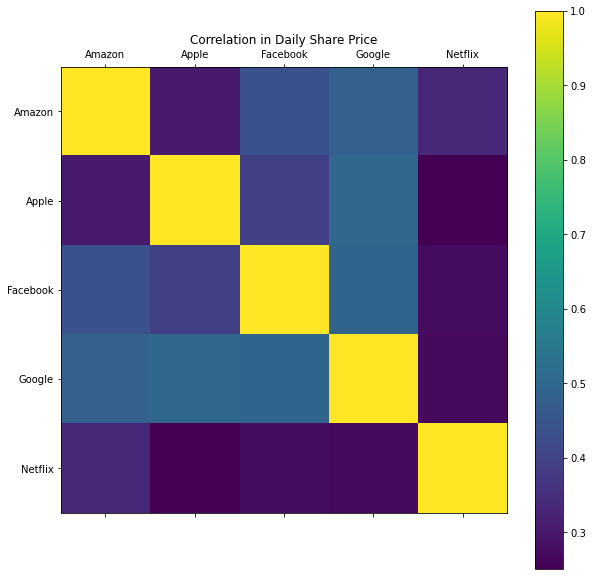

In [11]:
correlations = daily_returns.corr()
plt.rcParams['figure.figsize'] = (10,10)
plt.matshow(correlations)
plt.xticks(range(correlations.shape[1]), correlations.columns)
plt.yticks(range(correlations.shape[1]), correlations.columns)
plt.title('Correlation in Daily Share Price')
plt.colorbar()
plt.show()

As expected from the plots above, all the stocks are at least relatively correlated.

Interestingly, it would appear Netflix is the least correlated with the other companies, while Google is the most correlated. Let's keep this in mind for when we do our hypothesis testing.

We've analyzed closing prices quite a bit - let's take a look at other factors, and see how they interact with each other. We'll start by checking the correlation between them across all of the FAANG companies in the same way we just did for `pct_change`. We'll still be using the `pct_change()` function.  Without it the prices would stay largely the same, since we didn't observe many big swings above.

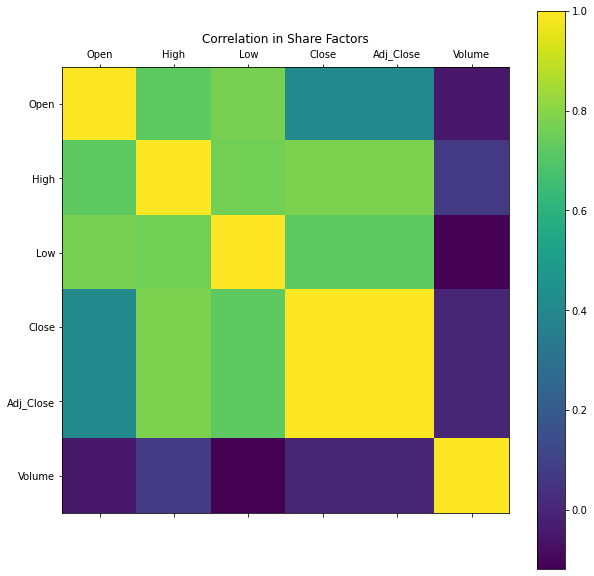

In [12]:
features = ['Open', 'High', 'Low', 'Close', 'Adj_Close', 'Volume']
correlations = price_data[features].pct_change().corr()
plt.rcParams['figure.figsize'] = (10,10)
plt.matshow(correlations)
plt.xticks(range(correlations.shape[1]), correlations.columns)
plt.yticks(range(correlations.shape[1]), correlations.columns)
plt.title('Correlation in Share Factors')
plt.colorbar()
plt.show()

Unsurprisingly, most of the price-related attributes are relatively correlated with each other, while Volume actually has a slight negative correlation. Let's see if we can replicate this during our hypothesis testing.

# Hypothesis Testing
From our exploratory data analysis, we found that Netflix was the least correlated with other FAANG stocks, while Google had the highest general correlation. Let's try regressing Netflix against the other FAANG stocks and see if the results are statistically significant.

In [13]:
model = smf.ols('Netflix ~ Facebook + Amazon + Apple + Google', daily_returns)
results = model.fit()
print("Netflix Regression Results:")
print(f"R^2: {round(results.rsquared, 2)}")
print(f"F-value: {round(results.fvalue, 2)} -> p = {results.f_pvalue}")
print("Variable, Coefficient, P value:")
for (i, v), p in zip(results.params.iteritems(), results.pvalues):
    print(f"{i} {round(v, 4)}, {round(p, 4)}")

Netflix Regression Results:
R^2: 0.21
F-value: 139.16 -> p = 2.3125329922569693e-105
Variable, Coefficient, P value:
Intercept 0.0012, 0.036
Facebook 0.0731, 0.015
Amazon 0.4501, 0.0
Apple -0.0004, 0.9911
Google 0.3755, 0.0


Interestingly, our regression resulted in an F statistic of 139.2, meaning the returns of other companies on the same day are jointly statistically significant. We also observed an R-squared of .21, which is relatively high. Though this model is not particularly useful without a time machine, it is still interesting to see nontheless that we can (with relative accuracy) predict Netflix's returns based on the returns of other companies.

One thing to note is that Apple is not statistically significant in this model.

Now let's take a look at regressing Google and see if we get an even better model.

In [14]:
model = smf.ols('Google ~ Facebook + Amazon + Apple + Netflix', daily_returns)
results = model.fit()
print("Google Regression Results:")
print(f"R^2: {round(results.rsquared, 2)}")
print(f"F-value: {round(results.fvalue, 2)} -> p = {results.f_pvalue}")
print("Variable, Coefficient, P value:")
for (i, v), p in zip(results.params.iteritems(), results.pvalues):
    print(f"{i} {round(v, 4)}, {round(p, 4)}")

Google Regression Results:
R^2: 0.49
F-value: 488.95 -> p = 1.5105030214424984e-296
Variable, Coefficient, P value:
Intercept -0.0001, 0.7355
Facebook 0.1386, 0.0
Amazon 0.2843, 0.0
Apple 0.2323, 0.0
Netflix 0.067, 0.0


As we guessed from our exploratory data analysis, the regression for Google is an even better model. The F test of overall significance points to the variables being statistically significant, with every individual company being statistically significant this time. Our R-squared is .487 this time - more than double that of our regression on Netflix.

Now that we've looked at daily returns, let's take a look at some of the other factors we saw above. Recall that `Volume` had a slight negative correlation with the other factors, so let's see what a regression yields:

In [15]:
model = smf.ols('Volume ~ Open + High + Low + Close + Adj_Close', price_data)
results = model.fit()
print("Volume Regression Results:")
print(f"R^2: {round(results.rsquared, 2)}")
print(f"F-value: {round(results.fvalue, 2)} -> p = {results.f_pvalue}")
print("Variable, Coefficient, P value:")
for (i, v), p in zip(results.params.iteritems(), results.pvalues):
    print(f"{i} {round(v, 4)}, {round(p, 4)}")

Volume Regression Results:
R^2: 0.15
F-value: 955.94 -> p = 0.0
Variable, Coefficient, P value:
Intercept 131342917.1872, 0.0
Open 310839.854, 0.5522
High -428388.6897, 0.4416
Low -320798.9244, 0.5395
Close 150781211.9155, 0.0
Adj_Close -150473591.376, 0.0


Interestingly enough, this model is quite jointly statistically significant with an F-value of 955. The R^2 is relatively low at just .15, which makes sense as Volume should have a lot of other factors influencing it outside of just price.

Based on the p-values, `Open`, `High`, and `Low` are all not individually statistically significant. Let's check if they are jointly statistically significant with an F-test. To do this, we'll run another regression without `Open`, `High`, or `Low` and compare the R^2. Thankfully, the `RegressionResults` we get from `model.fit()` provides us with a `compare_f_test` that makes this nice and easy. 

In [16]:
restricted_model = smf.ols('Volume ~ Close + Adj_Close', price_data)
restricted_results = restricted_model.fit()
f, p, _ = results.compare_f_test(restricted_results)
print(f"F = {round(f, 2)} -> p = {round(p, 2)}")

F = 0.24 -> p = 0.87


As the couplet goes, 'p-value low, reject the H0.' Our H0 in this case was that `Open`, `High`, and `Low` were not jointly significant, and the p-value here has confirmed our results. Before we move on, let's check the coefficients and see if this model is significantly different in other ways from the one above.

In [17]:
print("Restricted Volume Regression Results:")
print(f"R^2: {round(restricted_results.rsquared, 2)}")
print(f"F-value: {round(restricted_results.fvalue, 2)} -> p = {restricted_results.f_pvalue}")
print("Variable, Coefficient, P value:")
for (i, v), p in zip(restricted_results.params.iteritems(), restricted_results.pvalues):
    print(f"{i} {round(v, 4)}, {round(p, 4)}")

Restricted Volume Regression Results:
R^2: 0.15
F-value: 2389.7 -> p = 0.0
Variable, Coefficient, P value:
Intercept 131316139.0024, 0.0
Close 150357332.2092, 0.0
Adj_Close -150488809.1218, 0.0


The results here are basically identical to those above. Now, let's move on to some basic ML processing on our data.

# Machine Learning
Now that we've done some hypothesis testing with basic linear regression, let's jump into some fancier machine learning (ML) techniques to actually predict some prices.

To start, we'll see if we can just classify the direction of the return. Before we do this, there is some minor data engineering to attend to. Using our existing `pct_change` column, I will create a new binary variable called `increase`. `increase` will be 1 if the stock price went up or stayed flat, 0 if it went down. This way we can use some basic classification ML techniques. 

There is also a substantial risk of overfitting, especially in finance data. For a sanity check, I will be splitting our dataset into two - a training set (in sample) and a testing set (out of sample). For the purposes of this, we will consider data before January 1st, 2018 as in sample, and after as out of sample.

In [18]:
increase = [1 if i >= 0 else 0 for i in price_data['pct_change']]
price_data['increase'] = increase

training_data = price_data[price_data['Date'] < datetime.datetime(2018, 1, 1)]
testing_data = price_data[price_data['Date'] >= datetime.datetime(2018, 1, 1)]

Since most of `sklearn`'s functionality expects data as an array of the form `[[x11, x12, ..., x1k], [x21, x22, ..., x2k], ...]`, we need to convert our `DataFrame` to this type. We will use pandas' `iterrows`, which makes operations like this nice and simple. For this, we'll be using all the initial factors read from the original csv's: `[Open, High, Low, Low, Close, Adj_Close, Volume]`.

In [19]:
rows = ['Open', 'High', 'Low', 'Close', 'Adj_Close', 'Volume', 'pct_yesterday']
X = []
for i, row in training_data.iterrows():
    X.append([row[j] for j in rows])

X_testing = []
for i, row in testing_data.iterrows():
    X_testing.append([row[j] for j in rows])

First, we'll take a look at a logistic regression. A logistic regression is similar to the 'standard' OLS regression we used above, except isntead of predicting a continuous variable (like `pct_change`), it's used to predict categorical variables (like `increase`) In this case, we'll be using a Binary Logistic Regression, which can only predict a binary variable, making this perfect for `increase`. You can read more about logistic regression [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

In [20]:
y = training_data['increase']
reg = sklearn.linear_model.LogisticRegression()
reg = reg.fit(X, y)

So we've fitted our logistic regression. Now let's see how it performed on the dataset we trained it on and compare it to how it performs on our out of sample data.

In [21]:
training_prediction = reg.predict(X)
print(f'Logistic regression predicted {100 * sum(y == training_prediction) / len(y)}% correct in the training data.')
testing_prediction = reg.predict(X_testing)
y_testing = testing_data['increase']
print(f'Logistic regression predicted {100 * sum(y_testing == testing_prediction) / len(y_testing)}% correct in the testing data.')

Logistic regression predicted 52.04648160103292% correct in the training data.
Logistic regression predicted 54.036144578313255% correct in the testing data.


Interestingly, our logistic regression was marginally better in the testing than the training data. This is, however not particularly helpful, since a 52%/54% accuracy is only slightly better than flipping a coin for `increase`.

As expected then, we're going to need fancier tools if we have any hope of predicting the market. Before we do though, let's take a look at how our regression is weighing its inputs to see if it makes any logical sense or if we're just data mining.

In [22]:
print("Logistic Regression Coefficients:")
for coef, name in zip(reg.coef_[0], rows):
    print(f"{name}: {coef}")

Logistic Regression Coefficients:
Open: 3.3214095371715113e-16
High: 3.6410937967700024e-16
Low: 3.6267429886226363e-16
Close: 3.9416507420591985e-16
Adj_Close: 3.938252941920374e-16
Volume: 1.987387741483088e-10
pct_yesterday: -5.908365407437121e-21


There are two interesting parts of these coefficients. The coefficient on `pct_yesterday` being low is counterintuitive, as day-to-day momentum strategies tend to do reasonably well. Another is how impactful `Volume` is. I would never have expected the number of shares trading hand in a day to be that significant for predicting returns.

Let's step up from logistic regression to Random Forests. You can read about random forests [here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) and [here](https://en.wikipedia.org/wiki/Random_forest), but in essence they are a fancy version of using a bunch of different decision trees. Random forests are still prone to overfitting, but are less sensitive than the logistic regression used above.

In [23]:
rf = sklearn.ensemble.RandomForestClassifier()
rf = rf.fit(X, y)

In [24]:
training_prediction = rf.predict(X)
print(f'Random forests predicted {100 * sum(y == training_prediction) / len(y)}% correct in the training data.')
testing_prediction = rf.predict(X_testing)
print(f'Random forests predicted {100 * sum(y_testing == testing_prediction) / len(y_testing)}% correct in the testing data.')

Random forests predicted 100.0% correct in the training data.
Random forests predicted 59.1566265060241% correct in the testing data.


This is clearly a substantial improvement over logistic regression. Not only did we get a 100% accuracy for our in-sample data (likely most of the credit goes to overfitting), but we saw a 59% accuracy for our out of sample data.

Let's see how our random forests scored importance for each of our factors. 

In [25]:
print("Random Forest Importances:")
for importance, name in zip(rf.feature_importances_, rows):
    print(f"{name}: {importance}")

Random Forest Importances:
Open: 0.1819640737430069
High: 0.12721098681270482
Low: 0.12431012421469136
Close: 0.15496131201857063
Adj_Close: 0.1401041366358439
Volume: 0.1370738926235152
pct_yesterday: 0.13437547395166713


In contrast with the coefficients on the logistic regression, most of these are weighted relatively equally. Now that we have a model we are somewhat confident in, let's test it out.

# Testing our model
We'll use our random forest and test it against simply buying and holding each stock. Our simple buy and hold strategy will assume a 100% investment in Apple initially, and rebalance to include a new stock. For example, when Amazon goes on the market, we'll assume a 50/50 split between the two so that by the end of the data each stock will hold a 20% exposure.

Our random forest model will work slightly differently. We'll just focus on buying and selling (won't be shorting since it's outside the scope of this tutorial) each share. We'll calculate this based on whether we predict the stock to go up. If we predict it does, we'll buy it, otherwise we won't. Shares with a predicted increase will be equally weighted, just like our simple model.

We'll start by predicting `increase` for the entire dataset.

In [26]:
sorted_data = price_data.sort_values('Date').reset_index(drop=True)

rows = ['Open', 'High', 'Low', 'Close', 'Adj_Close', 'Volume', 'pct_yesterday']
X = []
for i, row in sorted_data.iterrows():
    X.append([row[j] for j in rows])
predicted_increase = rf.predict(X)
sorted_data['predicted_increase'] = predicted_increase

Now let's create a new variable, `strat_return`, which is the return for that day for the given stock when an increase is predicted. It is zero if we don't predict an increase.

In [27]:
strat_return = np.zeros(len(sorted_data))
for i, row in sorted_data.iterrows():
    if row['predicted_increase'] == 1:
        strat_return[i] = row['pct_change']
    else:
        strat_return[i] = 0
sorted_data['strat_return'] = strat_return

Now let's pull out the data we want to graph. For our buy and hold strategy, we can simply use the `daily_returns` table, which we created with `pivot()` above. For our Random Forests strategy, we can perform a similar operation, just only with days/stocks we predicted an increase for.

In [28]:
buy_and_hold = daily_returns.mean(axis=1).cumsum()
predicted_increase_data = sorted_data[sorted_data['predicted_increase'] == 1]
rf_daily_returns = predicted_increase_data.pivot(index='Date', columns='name', values='strat_return')
rf_strat = rf_daily_returns.mean(axis=1).cumsum()

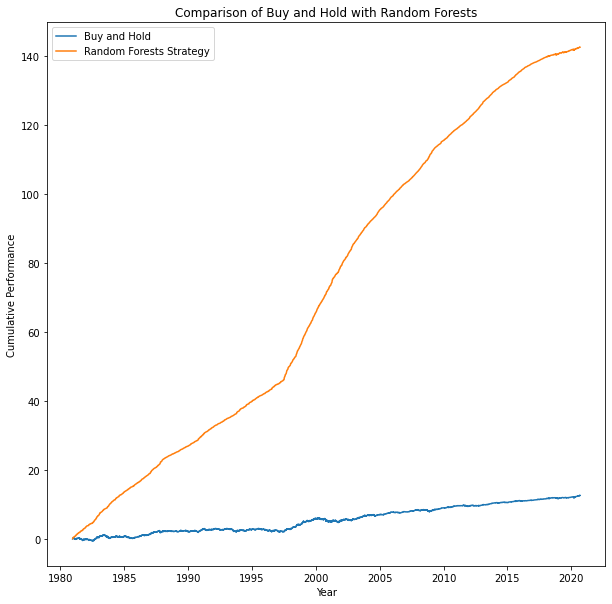

In [29]:
fig, ax = plt.subplots(figsize=(10,10))

ax.plot(buy_and_hold, label='Buy and Hold')
ax.plot(rf_strat, label='Random Forests Strategy')
ax.set_title('Comparison of Buy and Hold with Random Forests')
ax.set_xlabel('Year')
ax.set_ylabel('Cumulative Performance')
ax.legend()

Well that's a pretty significant difference. It is worth noting, that this is _absolutely_ not realistic in real life, since our model is likely overfitting significantly, especially within the training period. Nevertheless, it is a pretty graph to look at!

Let's really quickly take a look at how the strategy performs for individual stocks.

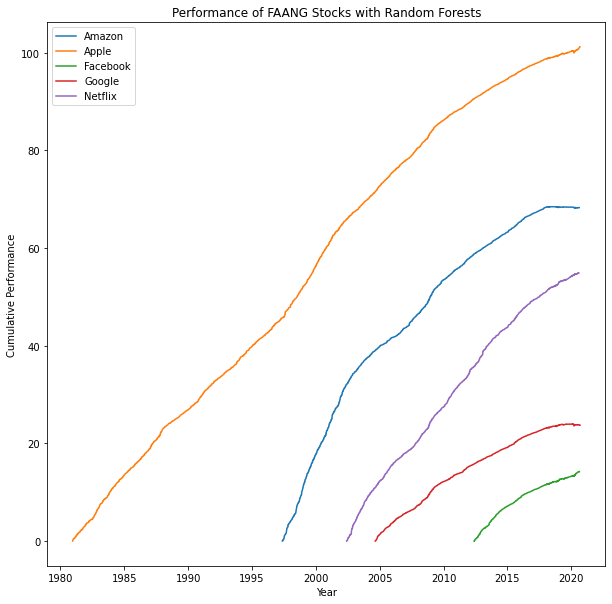

In [30]:
fig, ax = plt.subplots(figsize=(10,10))
for name, df in sorted_data.groupby('name'):
    ax.plot(df['Date'], df['strat_return'].cumsum(), label=name)
ax.set_title('Performance of FAANG Stocks with Random Forests')
ax.set_xlabel('Year')
ax.set_ylabel('Cumulative Performance')
ax.legend()

This is equally impressive, though it is absolutely worth noting that our performance putters out significantly in our testing period. This is extremely unlikely to continue, since we are benefitting from 35 years of overfitting.

# Conclusion
The performance we've observed is impressive on paper. However, as I've alluded to throughout this tutorial, overfitting is a very real problem. This is not only true of financial data either - overfitting is a persistent problem in data science and machine learning. With that said, however, the statistical and ML techniques used here are still extraodrinarily useful for most types of data. 

If nothing else, I hope you walk away with the realization that _data science is hard_, and that okay! There is always more to learn, and it is my sincere hope that you walk away from this tutorial with one or two things you didn't already know.

Thank you for reading, and a special thank you to José and the TAs that made CMSC320 possible!